## HW1: Time Series Analysis

This assignment will consist of a time series analysis for of a region of my choice. The format should be similar to the [Climate DataLab Time Series repository](https://github.com/climate-datalab/Time-Series-Plots). This exercise will be broken into five main steps

The directions are as follows:

Locate monthly data for a historical simulation run with any two CMIP6 models of your
choice. Data may be accessed either by download from the Earth System Grid Federation
MetaGrid, or through the Amazon Web Services cloud server.
(I recommend the cloud because it saves you some wrestling with downloading data files
and getting them transferred to your local machine!)
You may choose any climate variable you like; however, note that three-dimensional data is
generally larger and can be slower to load, so I recommend either choosing a two-
dimensional data field or reading in only the surface level if you choose 3D information.
Some common choices of variables to analyze, and their CMIP names, include:
- Surface air temperature (tas)
- Precipitation (pr)
- Sea surface temperature (tos)
However, you can refer to the list of standard CMIP variables or search through the ESGF
website for others if you like!
2. Download (or write Python code to access via the cloud) data from the historical simulation,
as well as corresponding future projection information for two different future emissions
scenarios, for each model. NOTE: particularly if you’re working with the ESGF, there are
many different scenarios listed - let’s stick to the main SSPs (they will be called ‘ssp126’,
‘ssp245’, ‘ssp370’, or ‘ssp585’).
- Make sure that the historical and SSP projection information match one another: that means
they need to come from the same model and the same ensemble member. You can refer to the
Climate DataLab filename decoder if you need some guidance on how to tell!
3. Choose a region that you’re interested in to analyze, anywhere in the world. The only
constraint is that your region needs to be large enough to include at least one model grid
point (see tutorials for more information).
a. Describe, in markdown text, the climate of that region in general terms. What is it like? Is
it a forest, a desert, polar, tropical, urban, etc? What types of climate change impacts might
you expect there?
b. Read in the surface air temperature datasets from 1 and 2, and create annually averaged,
area-weighted, regionally averaged time series for your region of interest. (Examples of how
to do this can be found in the various Time Series Plots tutorials we used in class.)
Since you’re working with two models and two scenarios, this should result in four time
series — however, if you used the same historical ensemble member for multiple scenarios,
they will end up lying on top of each other and that’s ok!
4. Plot your regional time series, and fit a trend line for two different time periods:
- historical (1850-2015)
- historical plus future (1850-2100)
Over both of those time periods, is the temperature of your region changing, and is that
change statistically significant?
5. Write 1-2 paragraphs in markdown text describing the results of your plot, and what you
think they might mean for humans or ecosystems located in your study region


### Load libraries and data

In [1]:
# Load libraries
import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')
catalog

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522217
dcpp_init_year,60


In [3]:
# Convert the catalog to a df for easier access
cat_df = catalog.df
cat_df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ta,gn,s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tauv,gn,s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,zg,gn,s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,vas,gn,s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/HighResMIP/CMCC/CMCC-CM2-...,NaN,20170706
...,...,...,...,...,...,...,...,...,...,...,...
522212,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,uas,gr,s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/...,NaN,20211207
522213,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,va,gr,s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/...,NaN,20211207
522214,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,wap,gr,s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/...,NaN,20211207
522215,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/...,NaN,20211207


In [4]:
# Let's view the types of models we have from source_id
cat_df.source_id.unique()

array(['CMCC-CM2-HR4', 'EC-Earth3P-HR', 'HadGEM3-GC31-MM',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LM', 'EC-Earth3P', 'ECMWF-IFS-LR',
       'ECMWF-IFS-HR', 'HadGEM3-GC31-LL', 'CMCC-CM2-VHR4', 'GFDL-CM4',
       'GFDL-AM4', 'IPSL-CM6A-LR', 'E3SM-1-0', 'CNRM-CM6-1', 'GFDL-ESM4',
       'GFDL-CM4C192', 'GFDL-ESM2M', 'GFDL-OM4p5B', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'CNRM-ESM2-1', 'BCC-CSM2-MR', 'BCC-ESM1', 'MIROC6',
       'AWI-CM-1-1-MR', 'EC-Earth3-LR', 'IPSL-CM6A-ATM-HR', 'CESM2',
       'CESM2-WACCM', 'CNRM-CM6-1-HR', 'MRI-ESM2-0', 'CanESM5',
       'SAM0-UNICON', 'GISS-E2-1-G-CC', 'UKESM1-0-LL', 'EC-Earth3',
       'EC-Earth3-Veg', 'FGOALS-f3-L', 'CanESM5-CanOE', 'INM-CM4-8',
       'INM-CM5-0', 'NESM3', 'MPI-ESM-1-2-HAM', 'CAMS-CSM1-0',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'MRI-AGCM3-2-H', 'MRI-AGCM3-2-S',
       'MCM-UA-1-0', 'INM-CM5-H', 'KACE-1-0-G', 'NorESM2-LM',
       'FGOALS-f3-H', 'FGOALS-g3', 'MIROC-ES2L', 'FIO-ESM-2-0', 'NorCPM1',
       'NorESM1-F', 'MPI-ESM1-2-XR'

### Let's narrow down the parameters of interest

In [5]:
# Specify search terms to query catalog for the two models
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: Two models for this exercise 
source_id = ['ACCESS-CM2', 'CAMS-CSM1-0']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

# member_id: which ensemble member do you want? Here we want r1i1p1f1
member_id = 'r1i1p1f1'

# table_id: Monthly atmosphere data
table_id = 'Amon' 

# variable_id: Precipitation 
variable_id = 'pr' 

In [6]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, experiment_id=experiment_ids, 
                     member_id=member_id, table_id=table_id, variable_id=variable_id)

res = res.df
res

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp370,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CAMS/CAMS-CSM...,NaN,20190708
1,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp585,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CAMS/CAMS-CSM...,NaN,20190708
2,CMIP,CAMS,CAMS-CSM1-0,historical,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CAMS/CAMS-CSM1-0/his...,NaN,20190708
3,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp126,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CAMS/CAMS-CSM...,NaN,20190708
4,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp245,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CAMS/CAMS-CSM...,NaN,20190708
5,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-...,NaN,20191108
6,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp370,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20191108
7,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp245,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20191108
8,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp126,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20210317
9,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20210317


In [7]:
# Dataframe for CAMS-CSM1-0 Model
res_csm1 = res[res['source_id'] == 'CAMS-CSM1-0']
res_csm1

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp370,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CAMS/CAMS-CSM...,NaN,20190708
1,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp585,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CAMS/CAMS-CSM...,NaN,20190708
2,CMIP,CAMS,CAMS-CSM1-0,historical,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CAMS/CAMS-CSM1-0/his...,NaN,20190708
3,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp126,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CAMS/CAMS-CSM...,NaN,20190708
4,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp245,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CAMS/CAMS-CSM...,NaN,20190708


In [8]:
# Dataframe for ACCESS CM2 Model
res_cm2 = res[res['source_id'] == 'ACCESS-CM2']
res_cm2

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
5,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-...,NaN,20191108
6,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp370,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20191108
7,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp245,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20191108
8,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp126,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20210317
9,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CSIRO-ARCCSS/...,NaN,20210317


### Step 3: Choose an area of interest
a. The area of interest for this exercise will be Yukushima Island, Japan. This is a humid subtropical climate that is considered one of the rainiest places in Japan, which is why i chose it. I am modeling how precipation will change given the different modeling scenarios, so I am interested in how Japan's rainiest place is effected. 


In [9]:
# Define min/max bounds for region of interest, Yukushima Island
lat_min, lat_max = 31.5, 32.0
lon_min, lon_max = 131.0, 131.8

b. Read in the surface air temperature datasets and create annualy averaged, area-weighted, regioniallly averaged timeseries for the area of interest.

### Annual Average for Yukushima Region for the CSM Model Scenarios

In [10]:
# Read in CSM1 historical data
hist_data_csm1 = xr.open_zarr(res_csm1['zstore'][2], storage_options = {'anon':True})

# Read in CSM1 SSP126 data
ssp126_data_csm1 = xr.open_zarr(res_csm1['zstore'][3], storage_options = {'anon':True})

# Read in CSM1 SSP245 data
ssp245_data_csm1 = xr.open_zarr(res_csm1['zstore'][4], storage_options = {'anon':True})

# Read in CSM1 SSP370 data
ssp370_data_csm1 = xr.open_zarr(res_csm1['zstore'][0], storage_options = {'anon':True})



In [11]:
# Concatenate data for scenario 1
csm1_scenario1 = xr.concat([hist_data_csm1, ssp370_data_csm1], dim = "time")

# Concatenate data for scenario 2
csm1_scenario2 = xr.concat([hist_data_csm1, ssp126_data_csm1], dim = 'time')

# Convert time to datetime64 format
time1_csm = csm1_scenario1.time.astype('datetime64[ns]')

# Convert time to datetime64 format
time2_csm = csm1_scenario2.time.astype('datetime64[ns]')

csm1_scenario1 = csm1_scenario1['pr']

csm1_scenario2 = csm1_scenario2['pr']

In [12]:
csm1_scenario2

<xarray.DataArray 'pr' (time: 3000, lat: 160, lon: 320)>
dask.array<concatenate, shape=(3000, 160, 320), dtype=float32, chunksize=(600, 160, 320), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * time     (time) object 1850-01-16 12:00:00 ... 2099-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        includes both liquid and solid phases
    history:        2019-07-01T12:19:04Z altered by CMOR: Inverted axis: lat.
    long_name:      Precipitation
    original_name:  precip
    standard_name:  precipitation_flux
    units:          kg m-2 s-1

### Plot Annual Mean for CSM Scenario 1

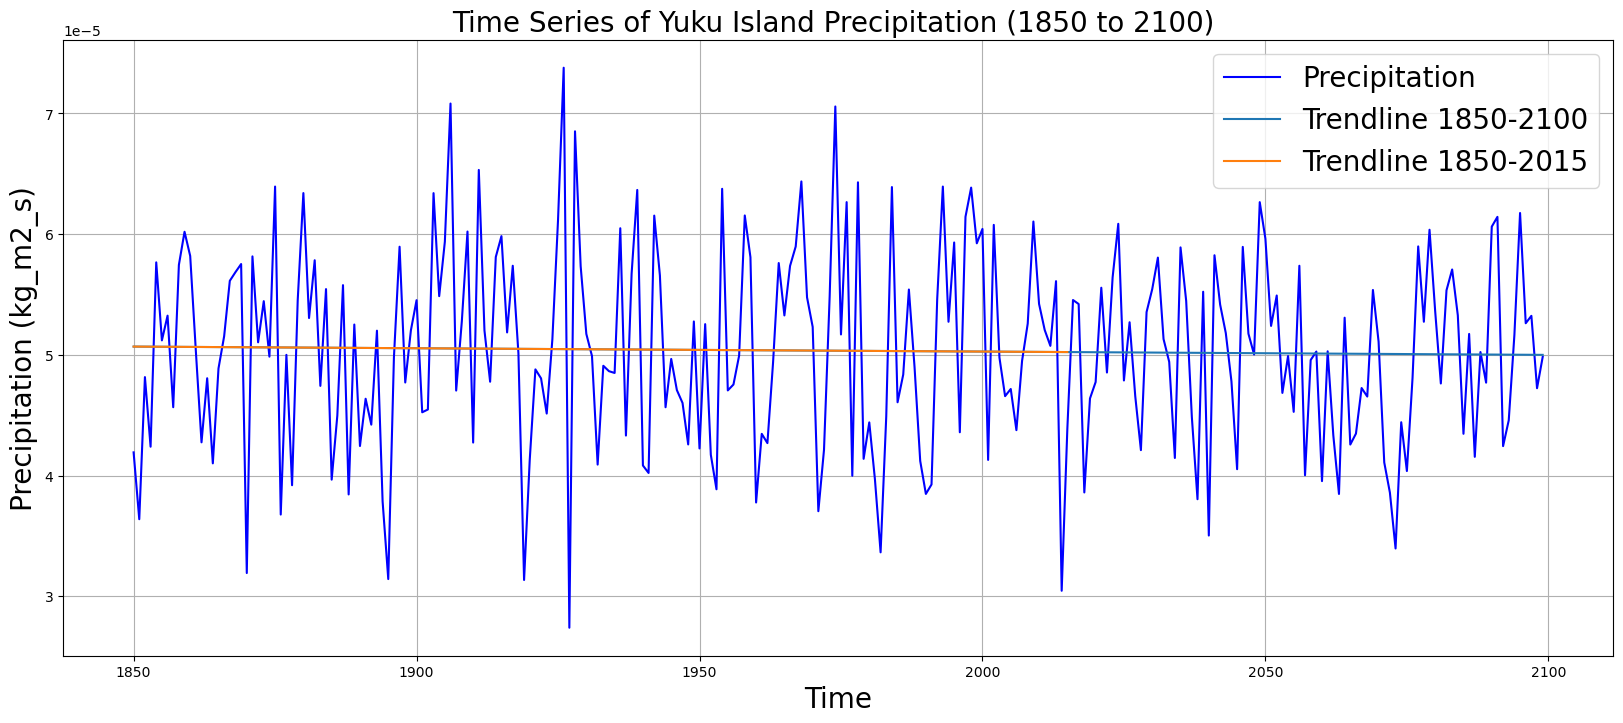

In [13]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
pr_yuku_lat = (csm1_scenario1.lat >= lat_min) & (csm1_scenario1.lat <= lat_max)
pr_yuku_lon = (csm1_scenario1.lon >= lon_min) & (csm1_scenario1.lon <= lon_max)

# Find poits where the mask value True, drop all other points
pr_yuku = csm1_scenario1.where(pr_yuku_lat & pr_yuku_lon, drop = True)

# Average over lat, lon dimensions to get a time series
pr_yuku = pr_yuku.mean(dim=['lat', 'lon'])


# Create annual mean for plot
annual_mean = pr_yuku.groupby('time.year').mean()
# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x = np.polyfit(annual_mean.year, annual_mean, 1)
# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x)  

# Trendline for filtered years 1850-2015
annual_mean_filtered = annual_mean.sel(year=slice(1850, 2015))
# Fit trendline to filtered data
x_filter = np.polyfit(annual_mean_filtered.year, annual_mean_filtered, 1)
# Create polynomial trendline function
trend_line_filter = np.poly1d(x_filter)

# Plot 
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(annual_mean.year, annual_mean, label='Precipitation', color='b')
ax.plot(annual_mean.year, trend_line(annual_mean.year), 
        label = "Trendline 1850-2100")
ax.plot(annual_mean_filtered.year, trend_line(annual_mean_filtered.year),
       label = "Trendline 1850-2015")

# Labels
ax.set_title("Time Series of Yuku Island Precipitation (1850 to 2100) ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Precipitation (kg_m2_s)", fontsize=20)

# Legend and show
ax.legend(fontsize=20)
ax.grid()
plt.show()

### Plot Annual Mean for CSM Scenario 2

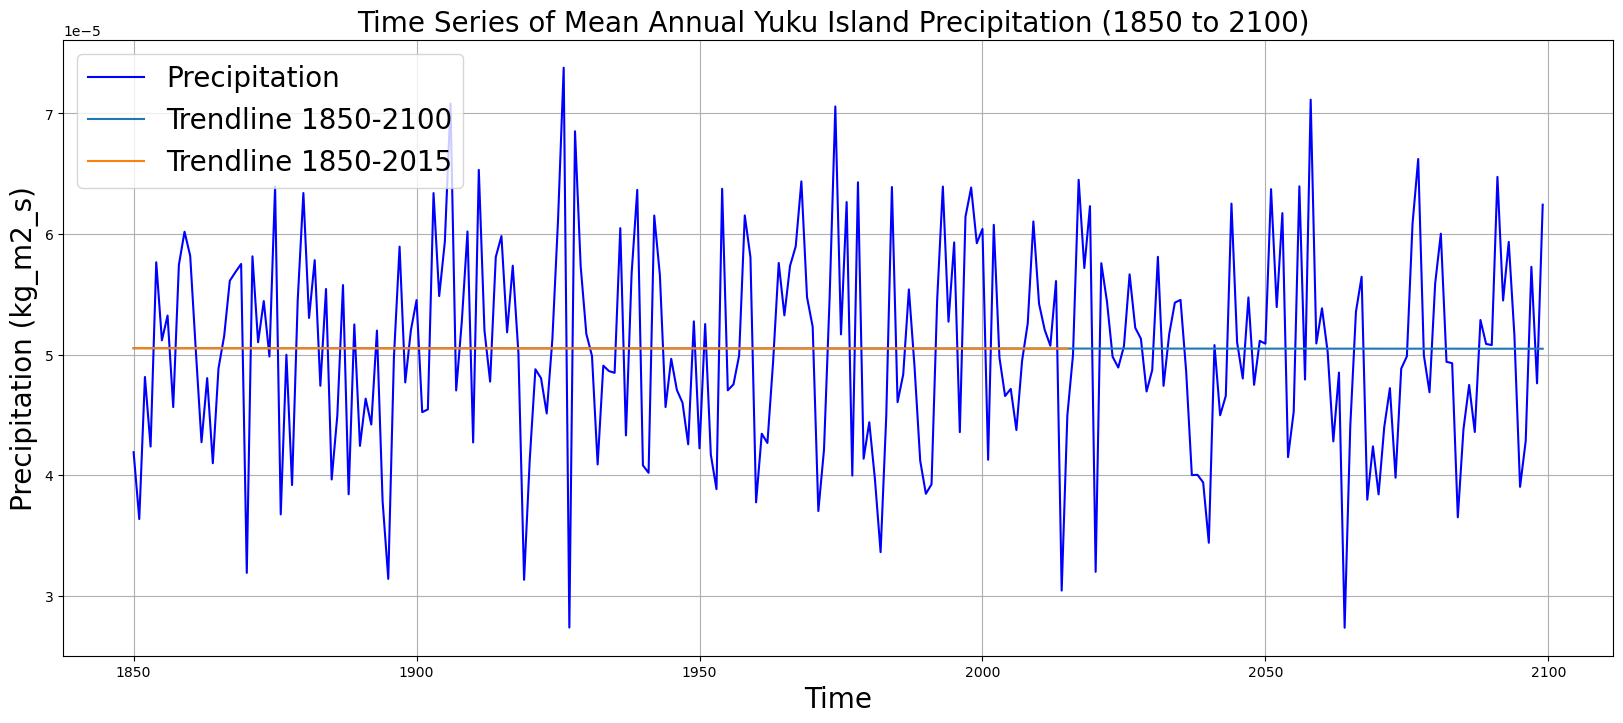

In [14]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
pr_yuku_lat = (csm1_scenario2.lat >= lat_min) & (csm1_scenario2.lat <= lat_max)
pr_yuku_lon = (csm1_scenario2.lon >= lon_min) & (csm1_scenario2.lon <= lon_max)

# Find poits where the mask value True, drop all other points
pr_yuku = csm1_scenario2.where(pr_yuku_lat & pr_yuku_lon, drop = True)

# Average over lat, lon dimensions to get a time series
pr_yuku = pr_yuku.mean(dim=['lat', 'lon'])

# Create annual mean for plot
annual_mean = pr_yuku.groupby('time.year').mean()
# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x = np.polyfit(annual_mean.year, annual_mean, 1)
# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x)  

# Trendline for filtered years 1850-2015
annual_mean_filtered = annual_mean.sel(year=slice(1850, 2015))
# Fit trendline to filtered data
x_filter = np.polyfit(annual_mean_filtered.year, annual_mean_filtered, 1)
# Create polynomial trendline function
trend_line_filter = np.poly1d(x_filter)

# Plot 
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(annual_mean.year, annual_mean, label='Precipitation', color='b')
ax.plot(annual_mean.year, trend_line(annual_mean.year), 
        label = "Trendline 1850-2100")
ax.plot(annual_mean_filtered.year, trend_line(annual_mean_filtered.year),
       label = "Trendline 1850-2015")

# Labels
ax.set_title("Time Series of Mean Annual Yuku Island Precipitation (1850 to 2100) ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Precipitation (kg_m2_s)", fontsize=20)

# Legend and show
ax.legend(fontsize=20)
ax.grid()
plt.show()

### Plot Annual Mean for the CM2 Models

In [15]:
# Read in CM2 historical data
hist_data_cm2 = xr.open_zarr(res_csm1['zstore'][0], storage_options = {'anon':True})

# Read in CM2 SSP126 data
ssp126_data_cm2 = xr.open_zarr(res_csm1['zstore'][3], storage_options = {'anon':True})

# Read in CM2 SSP245 data
ssp245_data_cm2 = xr.open_zarr(res_csm1['zstore'][2], storage_options = {'anon':True})

# Read in CM2 SSP370 data
ssp370_data_cm2 = xr.open_zarr(res_csm1['zstore'][1], storage_options = {'anon':True})


In [16]:
# Concatenate data for scenario 1
cm2_scenario1 = xr.concat([hist_data_cm2, ssp370_data_cm2], dim = "time")

# Concatenate data for scenario 2
cm2_scenario2 = xr.concat([hist_data_cm2, ssp126_data_cm2], dim = 'time')

# Convert time to datetime64 format
time1_cm2 = cm2_scenario1.time.astype('datetime64[ns]')

# Convert time to datetime64 format
time2_cm2 = cm2_scenario2.time.astype('datetime64[ns]')

cm2_scenario1 = cm2_scenario1['pr']

cm2_scenario2 = cm2_scenario2['pr']

In [17]:
cm2_scenario2

<xarray.DataArray 'pr' (time: 2040, lat: 160, lon: 320)>
dask.array<concatenate, shape=(2040, 160, 320), dtype=float32, chunksize=(600, 160, 320), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * time     (time) object 2015-01-16 12:00:00 ... 2099-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        includes both liquid and solid phases
    history:        2019-06-27T12:40:54Z altered by CMOR: Inverted axis: lat.
    long_name:      Precipitation
    original_name:  precip
    standard_name:  precipitation_flux
    units:          kg m-2 s-1

### Plot Annual Mean for CM2 Scenario 1

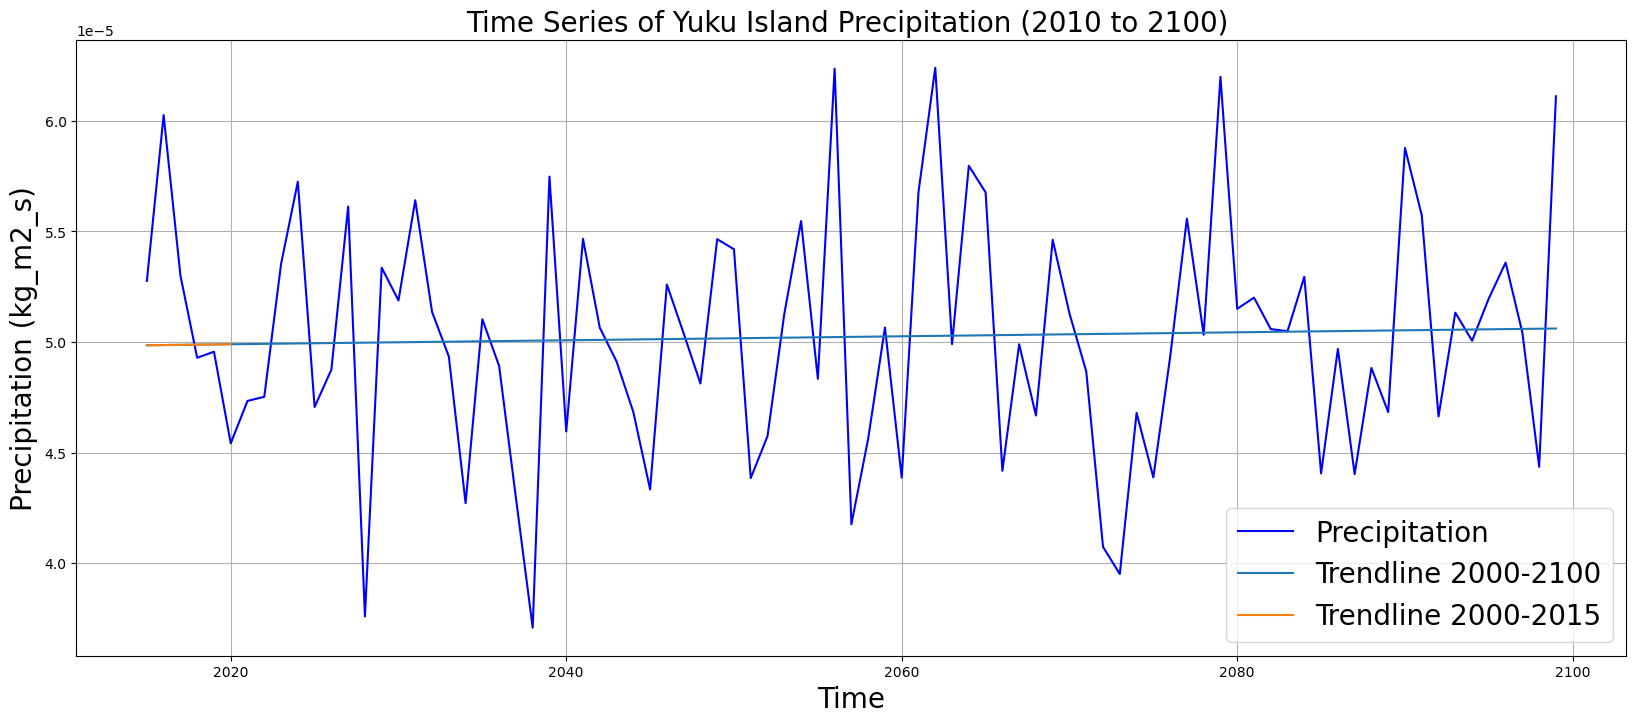

In [18]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
pr_yuku_lat = (cm2_scenario1.lat >= lat_min) & (cm2_scenario1.lat <= lat_max)
pr_yuku_lon = (cm2_scenario1.lon >= lon_min) & (cm2_scenario1.lon <= lon_max)

# Find poits where the mask value True, drop all other points
pr_yuku = cm2_scenario1.where(pr_yuku_lat & pr_yuku_lon, drop = True)

# Average over lat, lon dimensions to get a time series
pr_yuku = pr_yuku.mean(dim=['lat', 'lon'])

# Create annual mean for plot
annual_mean = pr_yuku.groupby('time.year').mean()
# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x = np.polyfit(annual_mean.year, annual_mean, 1)
# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x)  

# Trendline for filtered years 2000-2020
annual_mean_filtered = annual_mean.sel(year=slice(2000, 2020))
# Fit trendline to filtered data
x_filter = np.polyfit(annual_mean_filtered.year, annual_mean_filtered, 1)
# Create polynomial trendline function
trend_line_filter = np.poly1d(x_filter)


# Plot 
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(annual_mean.year, annual_mean, label='Precipitation', color='b')
ax.plot(annual_mean.year, trend_line(annual_mean.year), 
        label = "Trendline 2000-2100")
ax.plot(annual_mean_filtered.year, trend_line(annual_mean_filtered.year),
       label = "Trendline 2000-2015")

# Labels
ax.set_title("Time Series of Yuku Island Precipitation (2010 to 2100) ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Precipitation (kg_m2_s)", fontsize=20)

# Legend and show
ax.legend(fontsize=20)
ax.grid()
plt.show()

### Plot Annual Mean for CM2 Scenario 2

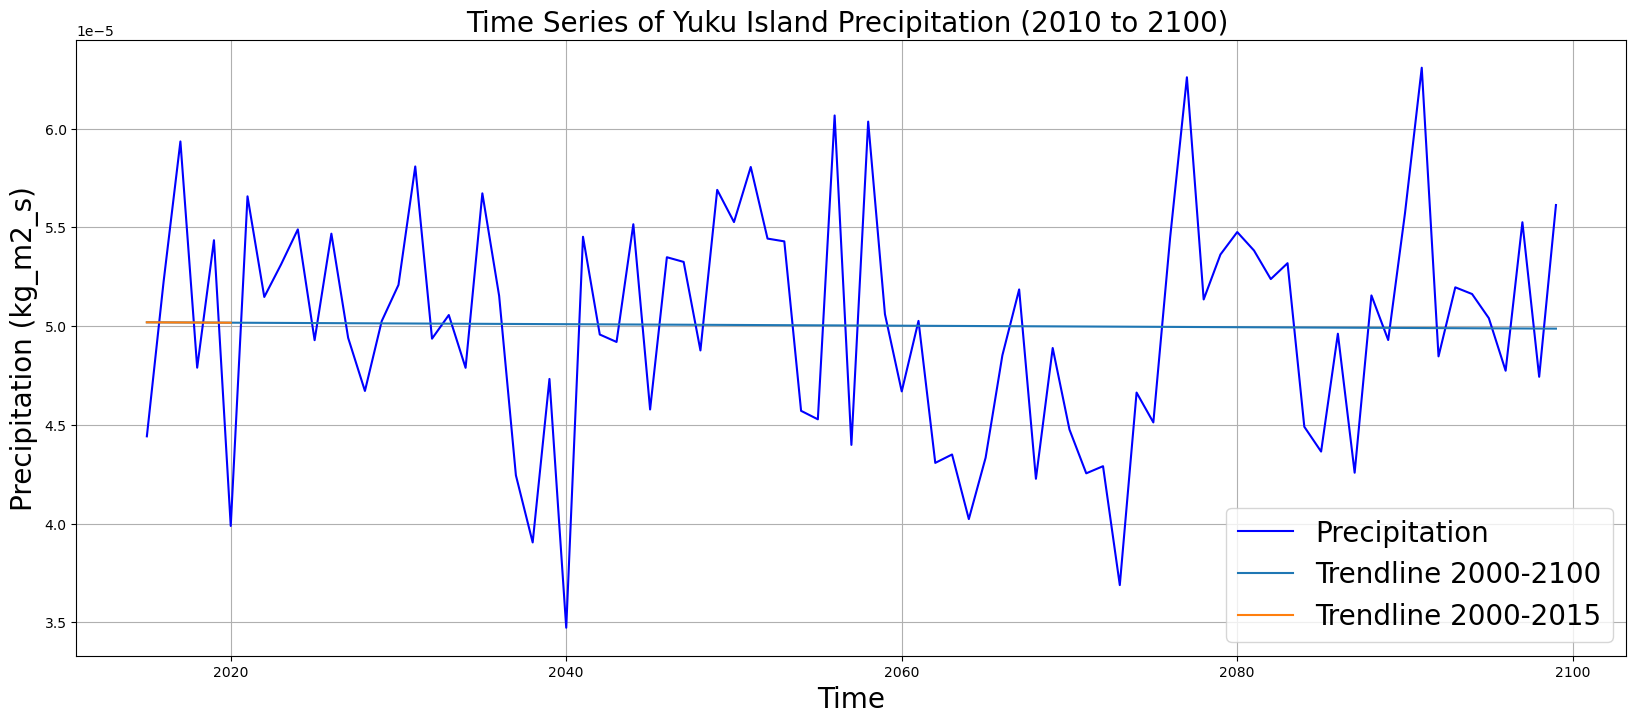

In [19]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
pr_yuku_lat = (cm2_scenario2.lat >= lat_min) & (cm2_scenario2.lat <= lat_max)
pr_yuku_lon = (cm2_scenario2.lon >= lon_min) & (cm2_scenario2.lon <= lon_max)

# Find poits where the mask value True, drop all other points
pr_yuku = cm2_scenario2.where(pr_yuku_lat & pr_yuku_lon, drop = True)

# Average over lat, lon dimensions to get a time series
pr_yuku = pr_yuku.mean(dim=['lat', 'lon'])


# Create annual mean for plot
annual_mean = pr_yuku.groupby('time.year').mean()
# Calculate best-fit parameters for the linear polynomial fit of temperature to year
x = np.polyfit(annual_mean.year, annual_mean, 1)
# Generate a polynomial object using those best-fit parameters
trend_line = np.poly1d(x)  


# Trendline for filtered years 2000-2020
annual_mean_filtered = annual_mean.sel(year=slice(2000, 2020))
# Fit trendline to filtered data
x_filter = np.polyfit(annual_mean_filtered.year, annual_mean_filtered, 1)
# Create polynomial trendline function
trend_line_filter = np.poly1d(x_filter)

# Plot 
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(annual_mean.year, annual_mean, label='Precipitation', color='b')
ax.plot(annual_mean.year, trend_line(annual_mean.year), 
        label = "Trendline 2000-2100")
ax.plot(annual_mean_filtered.year, trend_line(annual_mean_filtered.year),
       label = "Trendline 2000-2015")

# Labels
ax.set_title("Time Series of Yuku Island Precipitation (2010 to 2100) ", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Precipitation (kg_m2_s)", fontsize=20)

# Legend and show
ax.legend(fontsize=20)
ax.grid()
plt.show()

### Weight Grid Cells By Area for Each Scenario
We might notice that our trendlines are very horizontal, suggesting that there might not be any changes in precipitation over time for the four scenarios. We need to take into account that each grid cell has a different area because the earth is spherical. Let's do the same process, but weighting our grid cells first.

In [20]:
# Define function to generate area weights
def weights(dat):
    # Calculate weighting factor = cosine of latitude
    coslat = np.cos(np.deg2rad(dat.lat))
    weight_factor = coslat / coslat.mean(dim='lat')
    
    # Weight all points by the weighting factor
    computed_weight = dat * weight_factor
    
    # Return the set of weights: this has dimension equal to that of the input data
    return computed_weight

In [21]:
# Calculate weighted scenario for all four models
weighted_csm_scenario1 = weights(csm1_scenario1)

weighted_csm_scenario2 = weights(csm1_scenario2)

weighted_cm2_scenario1 = weights(cm2_scenario1)

weighted_cm2_scenario2 = weights(cm2_scenario2)

# Calculate Annual Mean Temp for all fource scenarios
weighted_csm_scenario1 = weighted_csm_scenario1.mean(dim=['lat', 'lon'])

weighted_csm_scenario2 = weighted_csm_scenario2.mean(dim=['lat', 'lon'])

weighted_cm2_scenario1 = weighted_cm2_scenario1.mean(dim=['lat', 'lon'])

weighted_cm2_scenario2 = weighted_cm2_scenario2.mean(dim=['lat', 'lon'])

We will do the same thing as above by calculating annual mean for the region with the given model. Afterwards we will plot to see the difference.

### Calculating New Annuals Based off Weighted Values

In [22]:
# CSM Scenario 1
weighted_csm1_1 = weighted_csm_scenario1
annual_weighted_csm1 = weighted_csm1_1.groupby('time.year').mean()

# CSM Scenario 2
weighted_csm1_2 = weighted_csm_scenario2
annual_weighted_csm1_2 = weighted_csm1_2.groupby('time.year').mean()

# CM2 Scenario 1
weighted_cm2_1 = weighted_cm2_scenario1
annual_weighted_cm2_1 = weighted_cm2_1.groupby('time.year').mean()

# CM2 Scenario 2
weighted_cm2_2 = weighted_cm2_scenario2
annual_weighted_cm2_2 = weighted_cm2_2.groupby('time.year').mean()

In [23]:
annual_weighted_cm2_1

<xarray.DataArray (year: 85)>
dask.array<stack, shape=(85,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2095 2096 2097 2098 2099

### Plot CSM Scenarios for Yukushima
#### CSM Scenario 1

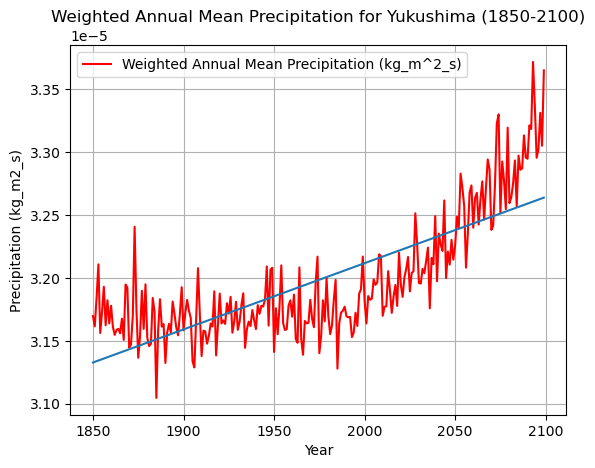

In [24]:
plt.figure()
plt.plot(annual_weighted_csm1.year, annual_weighted_csm1, label='Weighted Annual Mean Precipitation (kg_m^2_s)', color='red')


# Fit trendline to filtered data
x_filter = np.polyfit(annual_weighted_csm1.year, annual_weighted_csm1, 1)
# Create polynomial trendline function
trend_line = np.poly1d(x_filter)

# Add Trendline
plt.plot(annual_weighted_csm1.year, trend_line(annual_weighted_csm1.year))

# Labels
plt.xlabel('Year')
plt.ylabel('Precipitation (kg_m2_s)')
plt.title('Weighted Annual Mean Precipitation for Yukushima (1850-2100)')

# Legend and show
plt.legend()
plt.grid()
plt.show()

#### CSM Scenario 2

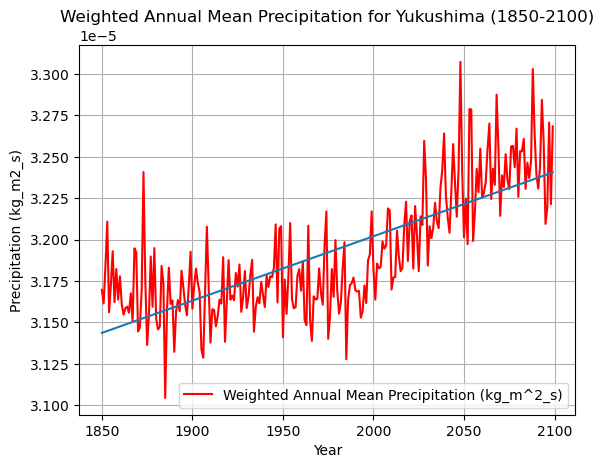

In [25]:
plt.figure()
plt.plot(annual_weighted_csm1_2.year, annual_weighted_csm1_2, label='Weighted Annual Mean Precipitation (kg_m^2_s)', color='red')

# Fit trendline to filtered data
x_filter = np.polyfit(annual_weighted_csm1_2.year, annual_weighted_csm1_2, 1)
# Create polynomial trendline function
trend_line = np.poly1d(x_filter)

# Add Trendline
plt.plot(annual_weighted_csm1_2.year, trend_line(annual_weighted_csm1_2.year))

# Labels
plt.xlabel('Year')
plt.ylabel('Precipitation (kg_m2_s)')
plt.title('Weighted Annual Mean Precipitation for Yukushima (1850-2100)')

# Legend and show
plt.legend()
plt.grid()
plt.show()

### Plot CM Scenarios for Yukushima
#### Scenario 1

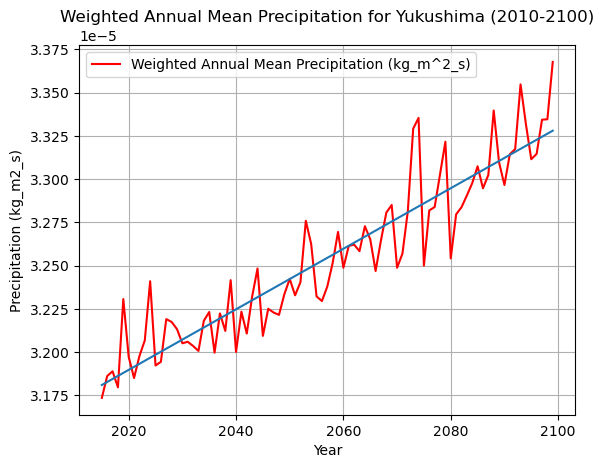

In [26]:
plt.figure()
plt.plot(annual_weighted_cm2_1.year, annual_weighted_cm2_1, label='Weighted Annual Mean Precipitation (kg_m^2_s)', color='red')

# Fit trendline to filtered data
x_filter = np.polyfit(annual_weighted_cm2_1.year, annual_weighted_cm2_1, 1)
# Create polynomial trendline function
trend_line = np.poly1d(x_filter)

# Add Trendline
plt.plot(annual_weighted_cm2_1.year, trend_line(annual_weighted_cm2_1.year))

# Labels
plt.xlabel('Year')
plt.ylabel('Precipitation (kg_m2_s)')
plt.title('Weighted Annual Mean Precipitation for Yukushima (2010-2100)')

# Legend and show
plt.legend()
plt.grid()
plt.show()

#### Scenario 2

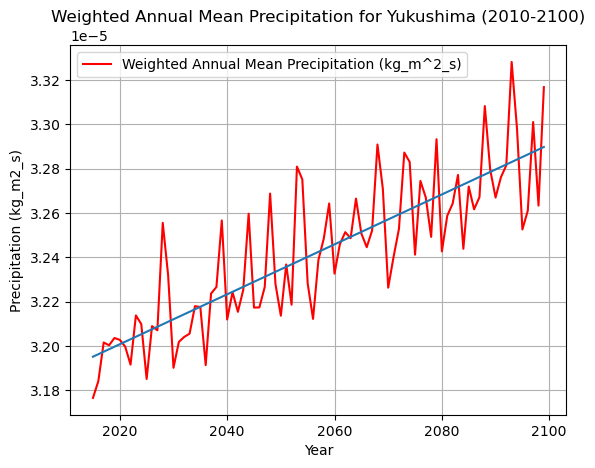

In [27]:
plt.figure()
plt.plot(annual_weighted_cm2_2.year, annual_weighted_cm2_2, label='Weighted Annual Mean Precipitation (kg_m^2_s)', color='red')

# Fit trendline to filtered data
x_filter = np.polyfit(annual_weighted_cm2_2.year, annual_weighted_cm2_2, 1)
# Create polynomial trendline function
trend_line = np.poly1d(x_filter)

# Add Trendline
plt.plot(annual_weighted_cm2_2.year, trend_line(annual_weighted_cm2_2.year))

# Labels
plt.xlabel('Year')
plt.ylabel('Precipitation (kg_m2_s)')
plt.title('Weighted Annual Mean Precipitation for Yukushima (2010-2100)')

# Legend and show
plt.legend()
plt.grid()
plt.show()

### Conclusions

From the original annual mean precipation plots for our scenarios, it is hard to tell if there are any significant changes in any of the scenarios. The trendline for each scenario is almost perfectly horizontal, suggesting no change. However, after weighting the grid cells, we see that there has been signficiant and will be significant changes over time. Each scenario has a an increase in precipitation over time. 

Increase in precipitation can be detrimental to both humans and other species. It can lead to flooding, infrastructure damage, soil degradation and more. One thing that should be noted is that Yukushima is relatively a rainy and lush place. Residents most likely already have implemented infrastructure to accomodate the rain intensity. 

One potential caveat to this analysis is the calculation of weighted grid cells. It is very important to weight grid cells when one is doing a global analysis, as their areas can drastically change. However, are the grid cells that encompass Yukushima drastically different? It would be interesting to look further into this, given more time. 